### Estimating Planetary Radii in Four Directions from JWST NIRSpec/G395H Observations (Alderson et al. 2023) of the WASP-39 b Transit

In [2]:
from wasp39b_params import period_day
from WASP39b_G395H_lightcurve import WASP39b_lightcurve
from calc_light_curve import transit_compute_flux_ecc0
from karate.calc_contact_times import calc_contact_times_circular
from karate.convert_ctv import (
    contact_times_to_delta_c_ingress_circular,
    contact_times_to_delta_c_egress_circular,
    rotate_delta_c_egress_circular,
    rotate_delta_c_ingress_circular,
    dcx_to_rp_spectra,
)
from karate.stellar_radius import rs_alpha_from_duration_Tc_circular

import numpy as np
import matplotlib.pyplot as plt

from jax import random
from jax import config
import jax.numpy as jnp

import numpyro
from numpyro import distributions as dist
from numpyro.infer import Predictive
from numpyro.infer import MCMC, NUTS
from numpyro.diagnostics import hpdi

config.update("jax_enable_x64", True)

Load the transit light curve.

In [3]:
period = period_day * 24 * 60 * 60

(
    time,
    wavelength,
    pre_tilt_f,
    pst_tilt_f,
    pre_tilt_f_err,
    pst_tilt_f_err,
) = WASP39b_lightcurve(resolution=100)
print(f"NRS1: {len(wavelength[0])} bin, NRS2: {len(wavelength[1])} bin")

time_nrs1 = time[0]
time_nrs2 = time[1]
wavelength_nrs1 = wavelength[0]
wavelength_nrs2 = wavelength[1]
flux_pre_tilt = jnp.concatenate((pre_tilt_f[0], pre_tilt_f[1]), axis=0)
flux_pst_tilt = jnp.concatenate((pst_tilt_f[0], pst_tilt_f[1]), axis=0)
flux_err_pre_tilt = jnp.concatenate((pre_tilt_f_err[0], pre_tilt_f_err[1]), axis=0)
flux_err_pst_tilt = jnp.concatenate((pst_tilt_f_err[0], pst_tilt_f_err[1]), axis=0)
flux_obs = jnp.concatenate((flux_pre_tilt, flux_pst_tilt), axis=1)
flux_err_obs = jnp.concatenate((flux_err_pre_tilt, flux_err_pst_tilt), axis=1)


NRS1: 29 bin, NRS2: 27 bin


The light curve data will be fitted with a transit light curve assuming zero eccentricity using Numpyro's Hamiltonian Monte Carlo (HMC). Since limb darkening coefficients, q1 and q2 (Kipping 2013), are expected to exhibit similar values for nearby wavelengths, we incorporated this by assuming a simple linear wavelength dependence for q1 and q2.

In [4]:
def u1u2_from_q1q2_linear(wavelength):
    # Limb darkening coefficients (Kipping 2013).
    # q1, q2: linear
    q1_wvmin = numpyro.sample("q1_wvmin", dist.Uniform(0, 1))
    q1_wvmax = numpyro.sample("q1_wvmax", dist.Uniform(0, 1))
    q2_wvmin = numpyro.sample("q2_wvmin", dist.Uniform(0, 1))
    q2_wvmax = numpyro.sample("q2_wvmax", dist.Uniform(0, 1))

    q1 = numpyro.deterministic(
        "q1",
        (q1_wvmax - q1_wvmin)
        / (jnp.max(wavelength) - jnp.min(wavelength))
        * (wavelength - jnp.min(wavelength))
        + q1_wvmin,
    )
    q2 = numpyro.deterministic(
        "q2",
        (q2_wvmax - q2_wvmin)
        / (jnp.max(wavelength) - jnp.min(wavelength))
        * (wavelength - jnp.min(wavelength))
        + q2_wvmin,
    )

    u1 = numpyro.deterministic("u1", 2 * q2 * jnp.sqrt(q1))
    u2 = numpyro.deterministic("u2", jnp.sqrt(q1) - u1)
    return u1, u2


def model_ecc0_u1u2(
    flux_obs,
    flux_err_obs,
    time_nrs1,
    time_nrs2,
    num_lightcurve_nrs1,
    num_lightcurve_nrs2,
    wavelength,
):

    period = period_day * 24 * 60 * 60
    num_lightcurve = num_lightcurve_nrs1 + num_lightcurve_nrs2

    t0 = numpyro.sample("t0", dist.Uniform(9000, 10000).expand([num_lightcurve]))
    depth = numpyro.sample("depth", dist.Uniform(0, 0.1).expand([num_lightcurve]))
    Ttot = numpyro.sample("Ttot", dist.Uniform(9000, 11000).expand([num_lightcurve]))

    theta_tot = 2 * jnp.pi * Ttot / period
    theta_full_max = 2 * jnp.arcsin(
        (1 - jnp.sqrt(depth)) / (1 + jnp.sqrt(depth)) * jnp.sin(theta_tot / 2)
    )
    Tfull_max = theta_full_max / 2 / jnp.pi * period
    Tfull = numpyro.sample("Tfull", dist.Uniform(1, Tfull_max))
    theta_full = 2 * jnp.pi * Tfull / period

    u1, u2 = u1u2_from_q1q2_linear(wavelength)
    c_base = numpyro.sample("c_base", dist.Uniform(0.99, 1.01).expand([num_lightcurve]))
    c_tilt = numpyro.sample("c_tilt", dist.Uniform(0.95, 1.05).expand([num_lightcurve]))
    jitter = numpyro.sample("jitter", dist.Uniform(0, 0.03).expand([num_lightcurve]))

    baseline_pre_tilt = jnp.ones(269 - 15) * c_base[:, None]
    baseline_pst_tilt = jnp.ones(465 - 272) * c_base[:, None] * c_tilt[:, None]
    baseline = jnp.concatenate((baseline_pre_tilt, baseline_pst_tilt), axis=1)

    rp_over_rs = jnp.sqrt(depth)
    a_over_rs = jnp.sqrt(
        (
            -((1 - jnp.sqrt(depth)) ** 2) * jnp.cos(theta_tot / 2) ** 2
            + (1 + jnp.sqrt(depth)) ** 2 * jnp.cos(theta_full / 2) ** 2
        )
        / jnp.sin((theta_tot + theta_full) / 2)
        / jnp.sin((theta_tot - theta_full) / 2)
    )
    cosi = jnp.sqrt(
        (
            (1 - jnp.sqrt(depth)) ** 2 * jnp.sin(theta_tot / 2) ** 2
            - (1 + jnp.sqrt(depth)) ** 2 * jnp.sin(theta_full / 2) ** 2
        )
        / (
            -((1 - jnp.sqrt(depth)) ** 2) * jnp.cos(theta_tot / 2) ** 2
            + (1 + jnp.sqrt(depth)) ** 2 * jnp.cos(theta_full / 2) ** 2
        )
    )
    flux_nrs1 = transit_compute_flux_ecc0(
        time_nrs1,
        rp_over_rs[:num_lightcurve_nrs1],
        t0[:num_lightcurve_nrs1],
        period,
        a_over_rs[:num_lightcurve_nrs1],
        cosi[:num_lightcurve_nrs1],
        u1[:num_lightcurve_nrs1],
        u2[:num_lightcurve_nrs1],
    )
    flux_nrs2 = transit_compute_flux_ecc0(
        time_nrs2,
        rp_over_rs[num_lightcurve_nrs1:],
        t0[num_lightcurve_nrs1:],
        period,
        a_over_rs[num_lightcurve_nrs1:],
        cosi[num_lightcurve_nrs1:],
        u1[num_lightcurve_nrs1:],
        u2[num_lightcurve_nrs1:],
    )
    flux = jnp.concatenate((flux_nrs1, flux_nrs2), axis=0)
    with numpyro.plate("wavelength", num_lightcurve_nrs1 + num_lightcurve_nrs2, dim=-2):
        with numpyro.plate("time", len(time_nrs1), dim=-1):
            numpyro.sample(
                "light_curve",
                dist.Normal(
                    flux * baseline,
                    jnp.sqrt(flux_err_obs**2 + jitter[:, None] ** 2),
                ),
                obs=flux_obs,
            )

In [5]:
# MCMC
rng_key = random.key(0)
rng_key, rng_key_ = random.split(rng_key)
kernel = NUTS(model_ecc0_u1u2)
mcmc = MCMC(kernel, num_warmup=1000, num_samples=1500)
mcmc.run(
    rng_key_,
    flux_obs=flux_obs,
    flux_err_obs=flux_err_obs,
    time_nrs1=time_nrs1,
    time_nrs2=time_nrs2,
    num_lightcurve_nrs1=int(len(wavelength_nrs1)),
    num_lightcurve_nrs2=int(len(wavelength_nrs2)),
    wavelength=jnp.concatenate((wavelength_nrs1, wavelength_nrs2)),
)

# mcmc.print_summary()

# Get samples
posterior_samples = mcmc.get_samples()

sample: 100%|██████████| 2500/2500 [04:08<00:00, 10.04it/s, 31 steps of size 1.28e-01. acc. prob=0.87] 


In [6]:
# Prediction
rng_key, rng_key_ = random.split(rng_key)
pred = Predictive(model_ecc0_u1u2, posterior_samples)
predictions = pred(
    rng_key_,
    flux_obs=None,
    flux_err_obs=flux_err_obs,
    time_nrs1=time_nrs1,
    time_nrs2=time_nrs2,
    num_lightcurve_nrs1=int(len(wavelength_nrs1)),
    num_lightcurve_nrs2=int(len(wavelength_nrs2)),
    wavelength=jnp.concatenate((wavelength_nrs1, wavelength_nrs2)),
)

Example of a Fitted Light Curve

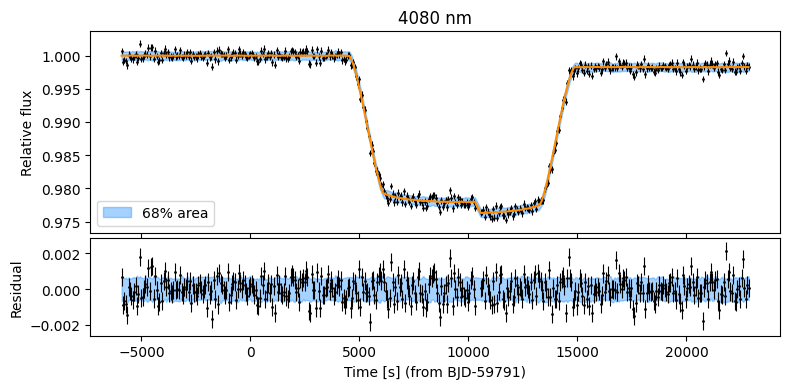

In [7]:
pred_median = np.median(predictions["light_curve"], axis=0)
pred_hpdi = hpdi(predictions["light_curve"], 0.68)

%matplotlib inline
index = 35
if index < len(wavelength_nrs1):
    time_plot = time_nrs1
    wavelength_plot = wavelength_nrs1[index]
else:
    time_plot = time_nrs2
    wavelength_plot = wavelength_nrs2[index - len(wavelength_nrs1)]
fig = plt.figure(figsize=(8, 4))
ax1 = fig.add_subplot(3, 1, (1, 2))
ax2 = fig.add_subplot(3, 1, 3)
ax1.errorbar(
    time_plot,
    flux_obs[index],
    yerr=flux_err_obs[index],
    fmt=".",
    markersize=2,
    linestyle="None",
    color="0.0",
    elinewidth=0.8,
    zorder=3,
)
ax1.plot(
    time_plot,
    pred_median[index],
    color="darkorange",
    zorder=5,
)
ax1.fill_between(
    time_plot,
    pred_hpdi[0, index],
    pred_hpdi[1, index],
    alpha=0.4,
    interpolate=True,
    color="dodgerblue",
    label="68% area",
)
ax1.set_title(f"{int(wavelength_plot)} nm")
# ax1.set_xlabel("Time [s]")
ax1.set_ylabel("Relative flux")
ax1.legend()

ax2.errorbar(
    time_plot,
    flux_obs[index] - pred_median[index],
    yerr=flux_err_obs[index],
    fmt=".",
    markersize=2,
    linestyle="None",
    color="0.0",
    elinewidth=0.8,
)
ax2.fill_between(
    time_plot,
    pred_hpdi[0, index] - pred_median[index],
    pred_hpdi[1, index] - pred_median[index],
    alpha=0.4,
    interpolate=True,
    color="dodgerblue",
    label="68% area",
)
# ax2.set_title("Residual")
ax2.set_xlabel("Time [s] (from BJD-59791)")
ax2.set_ylabel("Residual")

plt.setp(ax1.get_xticklabels(), visible=False)
plt.tight_layout()
plt.subplots_adjust(hspace=0.05)
plt.show()
plt.close()

From the estimated parameters, we will derive the planetary radius, the orbital semi-major axis, cos(orbital inclination), and the central transit time at each wavelength. Using these values, we will compute the contact times and convert them into the spectra of the planetary radius in four directions.

In [8]:
theta_tot = 2 * np.pi * posterior_samples["Ttot"] / period
theta_full = 2 * np.pi * posterior_samples["Tfull"] / period

sample_rp_over_rs = np.sqrt(posterior_samples["depth"])
sample_a_over_rs = np.sqrt(
    (
        -(1 - sample_rp_over_rs) ** 2 * np.cos(theta_tot / 2) ** 2
        + (1 + sample_rp_over_rs) ** 2 * np.cos(theta_full / 2) ** 2
    )
    / np.sin((theta_tot + theta_full) / 2)
    / np.sin((theta_tot - theta_full) / 2)
)
sample_cosi = np.sqrt(
    (
        (1 - sample_rp_over_rs) ** 2 * np.sin(theta_tot / 2) ** 2
        - (1 + sample_rp_over_rs) ** 2 * np.sin(theta_full / 2) ** 2
    )
    / (
        -((1 - sample_rp_over_rs) ** 2) * np.cos(theta_tot / 2) ** 2
        + (1 + sample_rp_over_rs) ** 2 * np.cos(theta_full / 2) ** 2
    )
)
sample_t1, sample_t2, sample_t3, sample_t4 = calc_contact_times_circular(
    sample_rp_over_rs, period, sample_a_over_rs, sample_cosi, posterior_samples["t0"]
)

To define a reference for asymmetry, we need to assume the position of the planetary center of mass. Here, we use the median values of the estimated orbital semi-major axis, cos(orbital inclination), and central transit time, averaged over wavelengths where the estimated planetary radius is below the 10th percentile. These averaged values are adopted as the orbital parameters of the planetary center of mass. The mean of these selected wavelengths serves as the reference when assuming the wavelength dependence of the stellar radius.

In [9]:
rp_median = np.median(sample_rp_over_rs, axis=0)
rp_small_indices = np.where(rp_median <= np.percentile(rp_median, 10))

a_over_rs_b = np.mean(np.median(sample_a_over_rs, axis=0)[rp_small_indices])
cosi_b = np.mean(np.median(sample_cosi, axis=0)[rp_small_indices])
t0_b = np.mean(np.median(posterior_samples["t0"], axis=0)[rp_small_indices])

wavelength_full = np.concatenate((wavelength_nrs1, wavelength_nrs2))
lambda0 = np.mean(wavelength_full[rp_small_indices])
print(f"Reference wavelength: {lambda0:.1f} nm" )

Reference wavelength: 3821.5 nm


Assuming that the wavelength-dependent slope of $T_c \sim (T_{tot}+T_{full})/2$ is caused by the wavelength dependence of the stellar radius, we compute the ratio $\alpha$ of the stellar radius at the reference wavelength to the stellar radius at each wavelength.

sample: 100%|██████████| 2000/2000 [00:07<00:00, 250.88it/s, 3 steps of size 3.13e-01. acc. prob=0.91] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
  intercept   8727.47      0.07   8727.47   8727.35   8727.59   1399.85      1.00
         nu     11.64      0.40     11.62     11.02     12.32    295.52      1.00
      sigma     20.78      0.08     20.78     20.65     20.92    322.03      1.00
      slope     19.94      0.12     19.95     19.74     20.14   1258.04      1.00

Number of divergences: 0


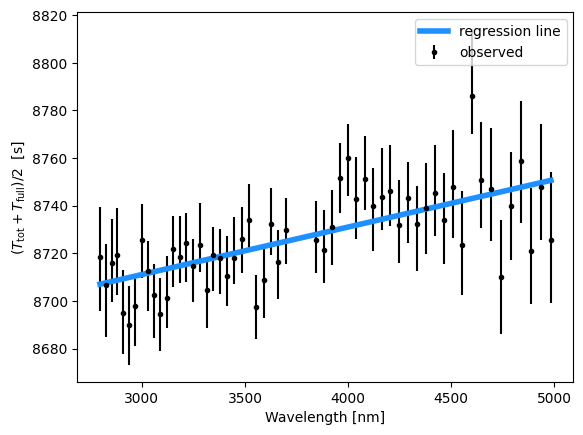

In [10]:

sample_Tc = (posterior_samples["Ttot"] + posterior_samples["Tfull"])/2
x = jnp.array((wavelength_full - lambda0) / 1000)
y = jnp.array(sample_Tc)
shape = y.shape
num_samples = len(y)

intercept_min = jnp.min(y)
intercept_max = jnp.max(y)
slope_min = -2 * (jnp.max(y) - jnp.min(y)) / (jnp.max(x) - jnp.min(x))
slope_max = 2 * (jnp.max(y) - jnp.min(y)) / (jnp.max(x) - jnp.min(x))

def model(x, y=None):
    intercept = numpyro.sample(
        "intercept", dist.Uniform(intercept_min, intercept_max)
    )
    slope = numpyro.sample("slope", dist.Uniform(slope_min, slope_max))
    sigma = numpyro.sample("sigma", dist.Exponential(1))
    nu = numpyro.sample("nu", dist.Exponential(1))
    mu = intercept + slope * x
    with numpyro.plate("y", num_samples, dim=-2):
        with numpyro.plate("x", len(x), dim=-1):
            numpyro.sample(
                "obs",
                dist.StudentT(
                    df=nu, loc=mu[None, :] * jnp.ones(shape), scale=sigma
                ),
                obs=y,
            )

# MCMC
rng_key, rng_key_ = random.split(rng_key)
nuts_kernel = NUTS(model)
mcmc = MCMC(nuts_kernel, num_samples=1000, num_warmup=1000)
mcmc.run(
    rng_key_,
    x=x,
    y=y,
)
mcmc.print_summary()
samples_Tcfit = mcmc.get_samples()

intercept_samples = samples_Tcfit["intercept"]
slope_samples = samples_Tcfit["slope"]

intercept = np.median(intercept_samples)
slope = np.median(slope_samples)


Tc_median = np.median(sample_Tc, axis=0)
Tc_hpdi = hpdi(sample_Tc, 0.68)
Tc_yerr = np.array([Tc_median - Tc_hpdi[0], Tc_hpdi[1] - Tc_median])

%matplotlib inline
fig = plt.figure()
ax = fig.add_subplot()
ax.errorbar(
    wavelength_full,
    Tc_median,
    yerr=Tc_yerr,
    color="black",
    fmt=".",
    label="observed",
)
ax.plot(
    wavelength_full,
    intercept + slope * ((wavelength_full - lambda0) / 1000),
    label="regression line",
    color="dodgerblue",
    lw=4,
)
ax.set_xlabel("Wavelength [nm]")
ax.set_ylabel("$(T_{\mathrm{tot}} + T_{\mathrm{full}})/2$  [s]")
plt.legend()
plt.show()
plt.close()


rs_alpha = rs_alpha_from_duration_Tc_circular(
    intercept + slope * ((wavelength_full - lambda0) / 1000),
    period,
    a_over_rs_b,
    cosi_b,
)
rs_alpha_lambda0 = rs_alpha_from_duration_Tc_circular(
    intercept,
    period,
    a_over_rs_b,
    cosi_b,
)
rs_alpha = rs_alpha / rs_alpha_lambda0


We then infer and plot the planetary radius spectra in four directions for two cases:
1. Assuming $\alpha=1$.

In [11]:
dc_X_ingress, dc_Y_ingress = contact_times_to_delta_c_ingress_circular(
    sample_rp_over_rs,
    sample_t1,
    sample_t2,
    period,
    np.mean(np.median(sample_a_over_rs, axis=0)),
    np.mean(np.median(sample_cosi, axis=0)),
    np.mean(np.median(posterior_samples["t0"], axis=0)),
    rs_alpha=1,
)
dc_X_egress, dc_Y_egress = contact_times_to_delta_c_egress_circular(
    sample_rp_over_rs,
    sample_t3,
    sample_t4,
    period,
    np.mean(np.median(sample_a_over_rs, axis=0)),
    np.mean(np.median(sample_cosi, axis=0)),
    np.mean(np.median(posterior_samples["t0"], axis=0)),
    rs_alpha=1,
)
dc_xi_ingress, dc_yi_ingress = rotate_delta_c_ingress_circular(
    dc_X_ingress, 
    dc_Y_ingress,
    np.mean(np.median(sample_a_over_rs, axis=0)),
    np.mean(np.median(sample_cosi, axis=0)),
)
dc_xe_egress, dc_ye_egress = rotate_delta_c_egress_circular(
    dc_X_egress, 
    dc_Y_egress,
    np.mean(np.median(sample_a_over_rs, axis=0)),
    np.mean(np.median(sample_cosi, axis=0)),
)
rp_xip, rp_xin = dcx_to_rp_spectra(
    sample_rp_over_rs, dc_xi_ingress, rs_alpha=1
)
rp_xep, rp_xen = dcx_to_rp_spectra(
    sample_rp_over_rs, dc_xe_egress, rs_alpha=1
)

The number of d < rs_alpha*k (ingress) [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 1 0 0 0]
The number of d < rs_alpha*k (egress) [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 1 0 0 0]


2. Using the $\alpha$ value estimated from $T_c \sim (T_{tot}+T_{full})/2$.

In [12]:
dc_X_ingress_rstrend, dc_Y_ingress_rstrend = contact_times_to_delta_c_ingress_circular(
    sample_rp_over_rs,
    sample_t1,
    sample_t2,
    period,
    np.mean(np.median(sample_a_over_rs, axis=0)),
    np.mean(np.median(sample_cosi, axis=0)),
    np.mean(np.median(posterior_samples["t0"], axis=0)),
    rs_alpha=rs_alpha,
)
dc_X_egress_rstrend, dc_Y_egress_rstrend = contact_times_to_delta_c_egress_circular(
    sample_rp_over_rs,
    sample_t3,
    sample_t4,
    period,
    np.mean(np.median(sample_a_over_rs, axis=0)),
    np.mean(np.median(sample_cosi, axis=0)),
    np.mean(np.median(posterior_samples["t0"], axis=0)),
    rs_alpha=rs_alpha,
)
dc_xi_ingress_rstrend, dc_yi_ingress_rstrend = rotate_delta_c_ingress_circular(
    dc_X_ingress_rstrend, 
    dc_Y_ingress_rstrend,
    np.mean(np.median(sample_a_over_rs, axis=0)),
    np.mean(np.median(sample_cosi, axis=0)),
)
dc_xe_egress_rstrend, dc_ye_egress_rstrend = rotate_delta_c_egress_circular(
    dc_X_egress_rstrend, 
    dc_Y_egress_rstrend,
    np.mean(np.median(sample_a_over_rs, axis=0)),
    np.mean(np.median(sample_cosi, axis=0)),
)
rp_xip_rstrend, rp_xin_rstrend = dcx_to_rp_spectra(
    sample_rp_over_rs, dc_xi_ingress_rstrend, rs_alpha=rs_alpha
)
rp_xep_rstrend, rp_xen_rstrend = dcx_to_rp_spectra(
    sample_rp_over_rs, dc_xe_egress_rstrend, rs_alpha=rs_alpha
)

The number of d < rs_alpha*k (ingress) [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 3 0 0 0 0 1 0 0 0]
The number of d < rs_alpha*k (egress) [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 3 0 0 0 0 1 0 0 0]


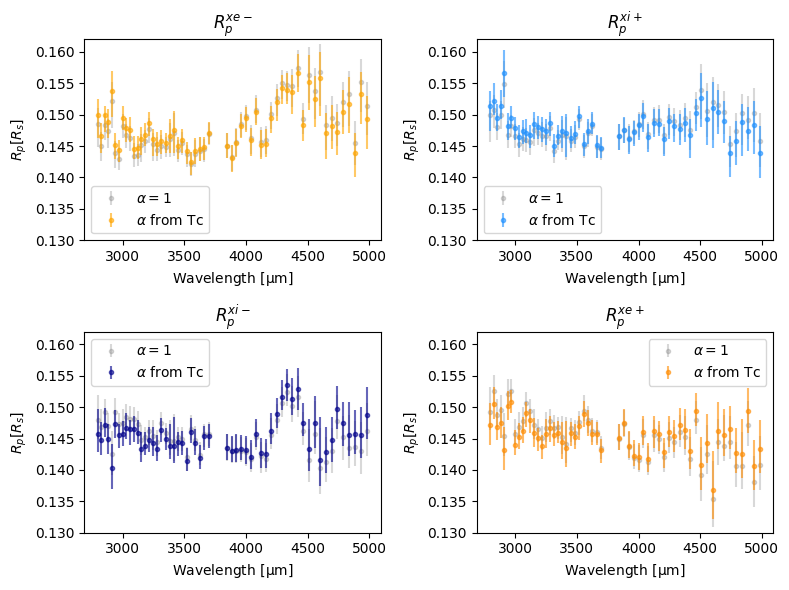

In [13]:
color = [["orange", "dodgerblue"], ["darkblue", "darkorange"]]
directions = [["$R_{p}^{xe-}$", "$R_{p}^{xi+}$"], ["$R_{p}^{xi-}$", "$R_{p}^{xe+}$"]]

rp_xip_median = np.median(rp_xip, axis=0)
rp_xip_hpdi = hpdi(rp_xip, 0.68)
rp_xip_err = [rp_xip_median - rp_xip_hpdi[0], rp_xip_hpdi[1] - rp_xip_median]

rp_xin_median = np.median(rp_xin, axis=0)
rp_xin_hpdi = hpdi(rp_xin, 0.68)
rp_xin_err = [rp_xin_median - rp_xin_hpdi[0], rp_xin_hpdi[1] - rp_xin_median]

rp_xep_median = np.median(rp_xep, axis=0)
rp_xep_hpdi = hpdi(rp_xep, 0.68)
rp_xep_err = [rp_xep_median - rp_xep_hpdi[0], rp_xep_hpdi[1] - rp_xep_median]

rp_xen_median = np.median(rp_xen, axis=0)
rp_xen_hpdi = hpdi(rp_xen, 0.68)
rp_xen_err = [rp_xen_median - rp_xen_hpdi[0], rp_xen_hpdi[1] - rp_xen_median]

rp_4_median = [[rp_xen_median, rp_xip_median], [rp_xin_median, rp_xep_median]]
rp_4_err = [[rp_xen_err, rp_xip_err], [rp_xin_err, rp_xep_err]]

rp_xip_rstrend_median = np.median(rp_xip_rstrend, axis=0)
rp_xip_rstrend_hpdi = hpdi(rp_xip_rstrend, 0.68)
rp_xip_rstrend_err = [rp_xip_rstrend_median - rp_xip_rstrend_hpdi[0], rp_xip_rstrend_hpdi[1] - rp_xip_rstrend_median]

rp_xin_rstrend_median = np.median(rp_xin_rstrend, axis=0)
rp_xin_rstrend_hpdi = hpdi(rp_xin_rstrend, 0.68)
rp_xin_rstrend_err = [rp_xin_rstrend_median - rp_xin_rstrend_hpdi[0], rp_xin_rstrend_hpdi[1] - rp_xin_rstrend_median]

rp_xep_rstrend_median = np.median(rp_xep_rstrend, axis=0)
rp_xep_rstrend_hpdi = hpdi(rp_xep_rstrend, 0.68)
rp_xep_rstrend_err = [rp_xep_rstrend_median - rp_xep_rstrend_hpdi[0], rp_xep_rstrend_hpdi[1] - rp_xep_rstrend_median]

rp_xen_rstrend_median = np.median(rp_xen_rstrend, axis=0)
rp_xen_rstrend_hpdi = hpdi(rp_xen_rstrend, 0.68)
rp_xen_rstrend_err = [rp_xen_rstrend_median - rp_xen_rstrend_hpdi[0], rp_xen_rstrend_hpdi[1] - rp_xen_rstrend_median]

rp_4_rstrend_median = [[rp_xen_rstrend_median, rp_xip_rstrend_median], [rp_xin_rstrend_median, rp_xep_rstrend_median]]
rp_4_rstrend_err = [[rp_xen_rstrend_err, rp_xip_rstrend_err], [rp_xin_rstrend_err, rp_xep_rstrend_err]]

%matplotlib inline
fig = plt.figure(figsize=(8,6))
for i in range(2):
    for j in range(2):
        ax = fig.add_subplot(2, 2, i*2+j+1)
        ax.errorbar(
            wavelength_full,
            rp_4_median[i][j],
            yerr=rp_4_err[i][j],
            color="gray",
            marker=".",
            linestyle="None",
            alpha=0.3,
            label="$\\alpha=1$"
        )
        ax.errorbar(
            wavelength_full,
            rp_4_rstrend_median[i][j],
            yerr=rp_4_rstrend_err[i][j],
            color=color[i][j],
            marker=".",
            linestyle="None",
            alpha=0.6,
            zorder=3,
            label="$\\alpha$ from Tc"
        )
        ax.set_ylim(0.13, 0.162)
        ax.set_title(directions[i][j])
        ax.set_xlabel("Wavelength [$\mathrm{\mu m}$]")
        ax.set_ylabel("$R_{p} [R_{s}]$")
        ax.legend()
plt.tight_layout()
plt.show()
plt.close()